In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, precision_score, recall_score,accuracy_score, classification_report

In [ ]:
df = pd.read_csv('MBA.csv')
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


# Pre-processing

In [ ]:
# Removing redundant fields
# Mapping strings to numerical labels
df = df.drop('application_id',axis=1)
df['international'] = df['international'].map({False: 0, True: 1})
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['admission'].fillna('Deny', inplace=True)
df.head()

<ipython-input-5-0b1bbb4b44b6>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['admission'].fillna('Deny', inplace=True)


,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,0,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,0,0,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,1,1,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,0,0,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,0,0,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny


In [ ]:
# Mapping the admission column to numerical values because RandomForest can't predict string labels
factor = pd.factorize(df['admission'])
df.admission = factor[0]
definitions = factor[1]
print(df.admission.head())
print(definitions)

0    0
1    1
2    0
3    1
4    1
Name: admission, dtype: int64
Index(['Admit', 'Deny', 'Waitlist'], dtype='object')


In [ ]:
X = df.drop(columns=['admission'], axis='columns')
y = df['admission']

# Feature Engineering

In [ ]:
# Creating two X datasets, one that combined international with race and one that doesn't
X_2 = X.copy(deep=True)

In [ ]:
# Dummy coding both training sets
X = pd.get_dummies(X, columns=['major', 'race', 'work_industry'])
X_2 = pd.get_dummies(X_2, columns=['major', 'race', 'work_industry'])

X_2.head(100)


,gender,international,gpa,gmat,work_exp,major_Business,major_Humanities,major_STEM,race_Asian,race_Black,...,work_industry_Health Care,work_industry_Investment Banking,work_industry_Investment Management,work_industry_Media/Entertainment,work_industry_Nonprofit/Gov,work_industry_Other,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology
0,1,0,3.30,620.0,3.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,0,3.28,680.0,5.0,False,True,False,False,True,...,False,False,True,False,False,False,False,False,False,False
2,1,1,3.30,710.0,5.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0,0,3.47,690.0,6.0,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
4,0,0,3.35,590.0,5.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,3.32,670.0,4.0,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
96,0,0,3.08,640.0,5.0,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,True
97,0,1,3.36,690.0,5.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
98,0,0,3.10,610.0,5.0,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [ ]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y, test_size = 0.3, random_state = 42)

In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

# Model Training

In [ ]:
# Decision Tree Classification
DecisionTree = DecisionTreeClassifier(
    criterion = 'entropy',
    random_state = 42)
DecisionTree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [ ]:
#Decision Tree Classification with Bagging
DecisionTreeWithBagging = BaggingClassifier(
    DecisionTree,
    n_estimators=100,
    n_jobs = -1)
DecisionTreeWithBagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   random_state=42),
                  n_estimators=100, n_jobs=-1)

# Model Prediction and Evaluation

In [ ]:
# Predicting the Test set results
y_pred = DecisionTree.predict(X_test)
y_pred2 = DecisionTreeWithBagging.predict(X2_test)

Metrics for - Decision Tree Classifier:

              precision    recall  f1-score   support

           0      0.352     0.318     0.334       299
           1      0.862     0.875     0.869      1525
           2      0.025     0.029     0.027        35

    accuracy                          0.770      1859
   macro avg      0.413     0.407     0.410      1859
weighted avg      0.764     0.770     0.767      1859

Metrics for - Decision Tree Classifier With Bagging:

              precision    recall  f1-score   support

           0      0.415     0.254     0.315       299
           1      0.848     0.931     0.887      1525
           2      0.000     0.000     0.000        35

    accuracy                          0.805      1859
   macro avg      0.421     0.395     0.401      1859
weighted avg      0.762     0.805     0.779      1859



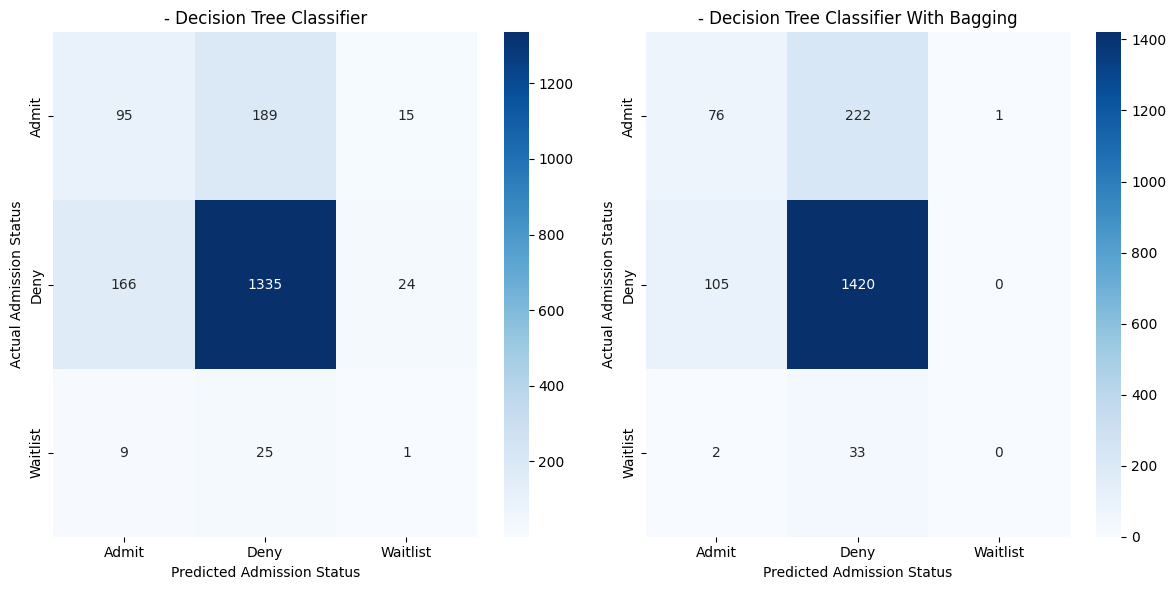

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

def confusionMatrix(y_preds, y_tests, titles, definitions):
    """
    Plots confusion matrices as subplots on a single figure.

    Args:
        y_preds: A list of predicted labels from different models.
        y_tests: A list of actual labels corresponding to the predictions.
        titles: A list of titles for each confusion matrix subplot.
        definitions: A list or Index of the original string labels for the target variable.
    """

    num_plots = len(y_preds)
    fig, axes = plt.subplots(1, num_plots, figsize=(12, 6))  # 1 row, num_plots columns

    for i, (y_pred, y_test, title) in enumerate(zip(y_preds, y_tests, titles)):
        reversefactor = dict(zip(range(len(definitions)), definitions))
        y_test_labels = np.vectorize(reversefactor.get)(y_test)
        y_pred_labels = np.vectorize(reversefactor.get)(y_pred)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Metrics for {title}:\n")
        print(classification_report(y_test, y_pred, digits=3))

        cm = confusion_matrix(y_test_labels, y_pred_labels, labels=definitions)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=definitions, yticklabels=definitions, ax=axes[i])
        axes[i].set_xlabel("Predicted Admission Status")
        axes[i].set_ylabel("Actual Admission Status")
        axes[i].set_title(title)

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()

# ... (rest of your code, including calling confusionMatrix) ...

# Call the function with both sets of predictions and labels to create the subplots:
confusionMatrix([y_pred, y_pred2], [y_test, y2_test],
               ['- Decision Tree Classifier', '- Decision Tree Classifier With Bagging'],
               definitions)